# Grundlagen der Künstlichen Intelligenz - Wintersemester 2024/25

# Übung 4: Variational Autoencoder

---

> 'Grundlagen der künstlichen Intelligenz' im Wintersemester 2024/2025
>
> - T.T.-Prof. Benjamin Schäfer, benjamin.schaefer@kit.edu
> - Prof. Gerhard Neumann, gerhard.neumann@kit.edu

---

In dieser Übung werden wir einen VariationalAutoencoder trainieren und verschiedene Anwendungsfälle betrachten. Wir werden in dieser Übung zum ersten Mal mit der Bibliothek PyTorch arbeiten. Schaut Euch dazu auch das folgende Einstiegstutorial an: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html, sowie das Pytorch Tutorial aus der Übung vom 06.12.24. Bei den jeweiligen Aufgaben findet Ihr weiter unten auch noch die relevanten Links zu spezifischer Dokumentation.

**Bitte verändert den Code nicht so, dass er auf der GPU läuft. Alle Aufgaben können ohne Probleme auf der CPU gelöst werden.**


### Übungsteam

- Sebastian Pütz, sebastian.puetz@kit.edu
- Ulrich Oberhofer, ulrich.oberhofer@kit.edu
- Philipp Dahlinger, philipp.dahlinger@kit.edu
- Nicolas Schreiber, nicolas.schreiber@kit.edu

# Gruppenabgabe

Die Übungsblätter können in Gruppen von bis zu **3 Studierenden** abgegeben werden. **Jede Person aus der Gruppe muss die finale Version der Abgabe über Ilias hochladen**, es genügt nicht, dass nur eine Person aus der Gruppe dies tut. Es ist prinzipiell möglich, im Laufe des Semesters sich einer neuen Gruppe anzuschließen, sollte sich die eigene Gruppe vorzeitig auflösen. Generell muss jede Gruppe ihre eigene Lösung hochladen, wir werden die Abgaben auf Duplikate überprüfen.

Die Gruppen werden automatisch erfasst, **gebt deshalb die u-Kürzel eurer Gruppenmitglieder in die folgende Zelle ein.** Falls eure Gruppe nur aus 2 Studierenden besteht, oder ihr alleine abgibt, lasst die verbleibenden Felder frei. Hier ein Beispiel für eine Gruppe bestehend aus uabcd und uefgh:

_U-Kürzel der Gruppenmitglieder:_

_Mitglied 1: uabcd_

_Mitglied 2: uefgh_

_Mitglied 3:_


U-Kürzel der Gruppenmitglieder:

Mitglied 1:

Mitglied 2:

Mitglied 3:


# Auto-grading

Wir nutzen ein auto-grading System, welches eure abgegebenen Jupyter Notebooks automatisch analysiert und über
hidden Tests auf Richtigkeit prüft. Über diese Tests werden die Punkte bestimmt, die ihr für das Übungsblatt erhaltet.

Damit das auto-grading reibungslos funktioniert bitte folgende Dinge beachten:

- Vor dem Abgeben eines Notebooks bitte testen, dass alles von vorne bis hinten ohne Fehler durchläuft.
- Zellen, welche mit "### DO NOT CHANGE ###" markiert sind dürfen weder gelöscht noch bearbeitet werden
- Eure Lösung muss in die richtige Zelle (markiert mit "# YOUR CODE HERE") eingetragen werden.
    - (dabei natürlich den NotImplementedError löschen!)
- Es gibt potentiell scheinbar leere Zellen, die auch mit "### DO NOT CHANGE ###" markiert sind. Auch diese dürfen nicht bearbeitet oder gelöscht werden.
    - Falls dies doch gemacht wird, dann wird das automatische Grading nicht funktionieren und ihr erhaltet keine Punkte.
    - Wir werden hier strikt handeln und keine Ausnahmen machen, falls jemand doch Zellen verändert, die eindeutig als readonly markiert sind!
- Die Jupyter Notebooks haben inline Tests (für euch sichtbar), welche euer Ergebnis auf grobe Richtigkeit überprüfen.
    - Diese sind primär für euch, um Fehler zu erkennen und zu korrigieren.
    - Die inline Tests, die ihr im Notebook sehen könnt, sind allerdings nicht die Tests welche für das Grading verwendet werden!
    - Die inline Tests sind eine notwendige Bedingung, um beim Grading der Aufgabe Punkte zu erhalten!

# **WICHTIG** Abgabe des Notebooks
- Bitte das Jupyter Notebook mit dem ursprünglichen Dateinamen ins Ilias hochladen ("ex_03_neural_networks.ipynb")
- Bitte Jupyter Notebook und handgeschriebene PDF einzeln hochladen, nicht als ZIP.
- Bitte darauf achten, dass die Jupyter Notebook Zell-Metadaten erhalten bleiben. Das ist eigentlich immer der Fall,
in wenigen Fällen gab es hier jedoch Probleme. Um auf Nummer Sicher zu gehen bitte das Notebook vor der Abgabe ein Mal
in einem normalen Texteditor öffnen und nach "nbgrader" suchen. Wenn hier dann keine entsprechenden JSON-Einträge auftauchen
dann sind leider die Metadaten verloren gegangen.

# Implementierung und Training des Variational Autoencoders

In dieser Übung implementieren und trainieren wir einen Variational Autoencoder. Ein Variational Autoencoder ist eine Subform des Autoencoders: Autoencoder bestehen aus einem Encoder- und einem Decoder-Netzwerk. Das Encoder-Netzwerk generiert dabei eine komprimierte, niederdimensionale Repräsentation des Inputs, der sogenannte Latent Space. Diese wird dann durch das Decoder Netzwerk wieder in eine Ausgabe transformiert, die die gleichen Dimensionen wie der ursprüngliche Input aufweist. Bei einem Variational Autoencoder besteht der Latent Space aus der Repräsentation des Mittelwerts und der Standardabeichung einer Normalverteilung, aus dieser dann mithilfe eines Reparametrisierungstricks ein Sample der Normalverteilung gebildet wird.
#### Autoencoder
![autoencoder.png](autoencoder.png)
#### Variational Autoencoder
![VAE.png](VAE.png)


Als erstes müssen wir wieder den Datensatz einlesen und verwenden dafür die Klasse `Dataset` aus `torch.utils`. Anschließend nutzen wir die (effiziente) Implementierung der `Dataloader` Klasse zur Iteration über Minibatches.

Beachtet während des ganzen Notebooks, dass PyTorch mit Daten im Format `torch.Tensor` arbeitet (anstelle von `numpy.array`). Beide Datenformate können aber einfach ineinander umgewandelt werden. Ihr findet an den entsprechenden Stellen im Verlauf des Notebooks die nötigen weiteren Informationen.

In [2]:
# imports
import os
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from functools import reduce
from operator import mul

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.squeeze(0))  # Remove the single channel dimension
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./', train=False, transform=transform, download=True)

batch_size = 128

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2886023.31it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 294490.43it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2155076.11it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1292612.89it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Als nächstes definieren wir eine Funktion zum Visualisieren der einzelnen Bilder und lassen uns jeweils die ersten
10 Bilder aus dem Trainings- und Testdatensatz anzeigen.

Train data examples:


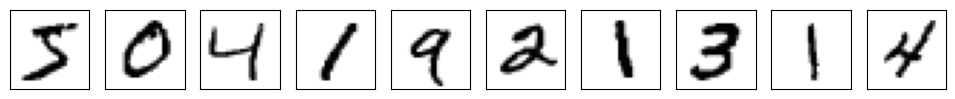

Test data examples:


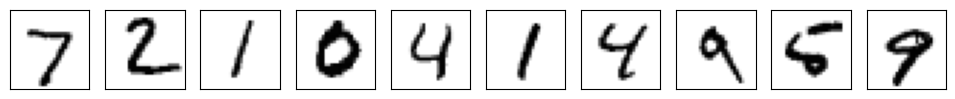

In [4]:
def visualize_data(batch_of_imgs):
    """
    batch_of_imgs: Sequence of two-dimensional torch.tensors
    return: None
    """
    num_imgs = len(batch_of_imgs)
    fig, ax = plt.subplots(1, num_imgs)
    if num_imgs == 1:
        # matplotlib does not create a list of axes when there is only 1 subplot created. To obtain the same
        # interface, we wrap it in a list.
        ax = [ax]
    wspace = 0.2
    fig.set_figwidth((0.6+wspace)*num_imgs-wspace)
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.0, wspace=wspace, hspace=0.1)
    for i in range(num_imgs):
        ax[i].imshow(1 - batch_of_imgs[i], cmap='gray')
        #ax[i].imshow(batch_of_imgs[i], cmap='gray')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    #plt.tight_layout()
    plt.show()
    
print("Train data examples:")
visualize_data([train_dataset[i][0] for i in range(10)])
print("Test data examples:")
visualize_data([test_dataset[i][0] for i in range(10)])

# Aufgabe 3.1 - Loss (1 + 1 Punkt)

Die Verlustfunktion/Loss ergibt sich aus der Variational Lower Bound, die es zu maximieren gilt (siehe VL 8, Folien 25 und 37): 
$$
     L( q,  \theta) = \sum_{i=1}^N \Big ( \mathbb E_{ z_i \sim q_{ \phi}( z_i| x_i)},
 \left [\log (p_\theta( x_i |  z_i) p( z_i)) \right ] - \mathbb E_{ z_i \sim q_{ \phi}( z_i| x_i)}\left [ \log q_{ \phi}( z_i |  x_i)\right ] \Big ).
 $$
In Aufgabe 4.1 zeigt ihr, dass wir die Variational Lower Bound umformen können zu 
\begin{align}
 L( q,  \theta) = \sum_{i=1}^N \Big (\mathbb E_{ z_i \sim q_{ \phi}( z_i| x_i)} \left [ \log p_{ \theta}( x_i |  z_i)\right ] - \mathbb E_{ z_i \sim q_{ \phi}( z_i| x_i)} \left [ \log q_{ \phi}( z_i |  x_i) - \log p( z_i) \right ] \Big ). \tag{1}
\end{align}
 Wir teilen das objective in die beiden Terme in der Summe auf, und erhalten den Reconstruktionsfehler/ Reconstuction loss $\mathbb E_{ z_i \sim q_{ \phi}( z_i| x_i)} \left [ \log p_{ \theta}( x_i |  z_i)\right ]$ sowie die sogenannte Kullback-Leibler-Divergenz $  \mathbb E_{ z_i \sim q_{ \phi}( z_i| x_i)} \left [ \log q_{ \phi}( z_i |  x_i) - \log p({z_i}) \right ]$.

**a) Rekonstruktionsfehler:** Der Rekonstruktionsfehler ist der erste Summand der umgeformten Variational Lower Bound (1). Wir konstruieren die Wahrscheinlichkeit $p_{\theta}(x|z)$ als Normalverteilung, als Rekonstruktionsfehler ergibt sich daher der Log-Likelihood-Loss und dementsprechend der MSE zwischen der Rekonstruktion und dem Input: <lr>
Wir betrachten die Verteilung $p_{\theta}( x_i |  z_i)$ als Normalverteilung mit konstanter Standardabweichung: $p_{\theta}( x_i |  z_i) = {N}( x_i |  \mu_{ \theta}( z_i), \sigma)$, wir betrachten also ${\hat{x}_i} = \mu_\theta (z_i)$ als Output des Variational Autoencoders. Wir können den Log-Likelihood-Loss in den MSE-Loss umwandeln; :
$$\log p_{{\theta}}({x}_i | {z}_i) = -\frac{1}{2\sigma^2} \|{x}_i - {\mu}_{{\theta}}({z}_i)\|^2 - \frac{d}{2} \log(2\pi\sigma^2)$$
Der zweite Term, $-\frac{d}{2} \log(2\pi\sigma^2)$ ist konstant in Bezug auf die Optimierungsparameter ${\theta}$ und hat keinen Einfluss auf die Gradienten während des Trainings. Wir erhalten
$$
\mathbb{E}_{{z}_i \sim q_{{\phi}}({z}_i|{x}_i)} \left [ \log p_{{\theta}}({x}_i | {z}_i)\right ] \propto -\frac{1}{2\sigma^2} \mathbb{E}_{{z}_i \sim q_{{\phi}}({z}_i|{x}_i)} \left[ \|{x}_i - {\mu}_{{\theta}}({z}_i)\|^2 \right]
$$
In der Praxis approximieren wir den Erwartungswert pro Datensample ${x_i}$ aus unserem Datensatz durch ein einzelnes sampling von $z_i$ aus $q_{{\phi}}({z}_i|{x}_i)$.
Somit beschreiben wir den zu minimierenden Rekonstruktionsfehler (für jedes Sample i) durch:
$\|{x}_i - {\mu}_{{\theta}}({z}_i)\|^2 = \|{x}_i - {\hat{x}_i}\|^2$.<lr> Jetzt könnt ihr den Rekonstruktionsfehler selbst implementieren.
Summiert dazu den Error $\|{x}_i - {\hat{x}_i}\|^2$ über die geflattende Dimension (Beispiel für flatten: Aus Dimensionen (28,28) wird Dimension 28*28) des einzelnen Input-Samples auf, und nehmt anschließend den Durchschnitt über die gesamte Batch mit Batchgröße $B$:
$$
\text{Reconstruction Loss} = \frac{1}{B} \sum_{i=1}^B \sum_{j=1}^{d} ({x}_{i,j} - {\hat{x}}_{i,j})^2
$$

In [5]:
def reconstruction_loss(x: torch.Tensor, x_recon: torch.Tensor) -> torch.Tensor:
    """
    Computes the reconstruction loss between the data tensor `x` and the reconstructed tensor `x_recon`
    Args:
    x (torch.Tensor): Original data tensor. Shape: (batch_size, *data_dims)
    x_recon (torch.Tensor): Reconstructed tensor. Shape: (batch_size, *data_dims)
    Returns:
    The reconstruction loss for the batch
    """
    x_flat= x.flatten(start_dim=1)
    x_recon_flat = x_recon.flatten(start_dim=1)
    loss = None
    ### BEGIN SOLUTION
    loss = ((x_flat - x_recon_flat) ** 2).sum(dim=1)
    ### END SOLUTION
    return loss.mean() #return the average loss over the batch


**b) Kullback-Leibler-Divergenz (KL-Divergenz):** Allgemein ist für 2 diskrete Wahrscheinlichkeitsverteilungen $Q,P$ auf einer Menge $X$ mit Wahrscheinlichkeitsfunktionen $q,p$ die Kullback-Leibler-Divergenz für $Q$ und $P$ gegeben als $D(Q\|P) = KL(Q\|P) = \sum_{x \in X}q(x)\log \left ( \frac{q(x)}{p(x)} \right )$. Wir sehen, dass der zweite Term aus Gleichung (1), $\mathbb E_{ z_i \sim q_{ \phi}( z_i| x_i)} \left [ \log q_{ \phi}( z_i |  x_i) - \log p( z_i) \right ]$, genau der KL-Divergenz zwischen den Verteilungen $q_{ \phi}( z_i |  x_i)$ und $p( z_i)$ entspricht. Da dieser Erwartungswert ein negatives Vorzeichen in der Variational Lower Bound hat, wollen wir ihn entsprechend minimieren. Wir bezeichnen diesen Teil der Loss-Funktion im Folgenden als Kullback-Leibler-Loss. <lr>
In Aufgabe 4.1 zeigt ihr, dass für Normalverteilungen<lr>
$$
q(z) = {N}(z|\mu, \sigma^2), \qquad p(z) = {N}(z|0, 1)
$$
 folgende Umformung gilt:
$$
    \mathbb E_{ z_i \sim q_{ \phi}( z_i| x_i)} \left [ \log q_{ \phi}( z_i |  x_i) - \log p( z_i) \right ]  = \sum_{j=1}^d \mathbb E_{z_j \sim q_j(z_j)} \left [ \log q_j(z_j) - \log p_j(z_j) \right ] 
    = -\frac{1}{2} \sum_{j = 1}^d \big(1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2\big)
$$
In unserem Fall entspricht $d$ der Dmension des Latent Space. Anschließend wird der Mittelwert über die gesamte Batch berechnet. Implementiert im Folgenden den Kullback-Leibler-Loss auf diese Weise:
$$
\text{KL Loss} = \frac{1}{B} \sum_{i=1}^B \left( -\frac{1}{2} \sum_{j = 1}^d \big(1 + \log(\sigma_{i,j}^2) - \mu_{i,j}^2 - \sigma_{i,j}^2\big) \right)
$$

In [6]:
def gaussian_kullback_leibler(mu_q: torch.Tensor, sigma_q: torch.Tensor) -> torch.Tensor:
    """
    Computes the KL divergence between a Gaussian distribution q 
    (with mean `mu_q` and standard deviation `sigma_q`) and a standard Gaussian distribution p.
    Args:
    mu_q (torch.Tensor): Mean of the Gaussian distribution q. Shape: (batch_size, latent_dims)
    sigma_q (torch.Tensor): Standard deviation of the Gaussian distribution q. Shape: (batch_size, latent_dims)
    Returns:
    The scalar KL divergence
    """
    kl = None
    ### BEGIN SOLUTION
    kl = (0.5 * torch.sum(mu_q ** 2 + sigma_q ** 2 - torch.log(sigma_q ** 2) - 1, dim=1))
    ### END SOLUTION
    return kl.mean() #return the KL divergence averaged over the batch

In [7]:
# reconstruction loss
assert torch.isclose(reconstruction_loss(torch.ones(1, 2, 2), torch.ones(1, 2, 2)), torch.zeros(1)), "Loss should be zero for perfect reconstruction"
assert reconstruction_loss(torch.zeros(3, 2, 2), torch.ones(3, 2, 2)).item() == 4, "Wrong reconstruction loss"

In [8]:
# KL divergence
assert torch.isclose(gaussian_kullback_leibler(torch.zeros(1, 2), torch.ones(1, 2)), torch.zeros(1)), "KL should be zero for standard normal"
assert gaussian_kullback_leibler(torch.ones(3, 2), torch.ones(3, 2)).item() == 1, "Wrong KL divergence calculation"

mu_q = torch.tensor([[1.0, 2.0, 3.0],
                        [0.5, 0.5, 0.5]])
sigma_q = torch.tensor([[1.0, 1.0, 1.0],
                        [1.0, 1.0, 1.0]])  # Only mu_q is non-zero
kl_correct = (0.5 * torch.sum(mu_q ** 2 + sigma_q ** 2 - torch.log(sigma_q ** 2) - 1, dim=1)).mean()
assert torch.isclose(gaussian_kullback_leibler(mu_q, sigma_q), kl_correct)

mu_q = torch.zeros(2, 3)
sigma_q = torch.tensor([[10.0, 10.0, 10.0],
                        [10.0, 10.0, 10.0]])
kl_correct = (0.5 * torch.sum(mu_q ** 2 + sigma_q ** 2 - torch.log(sigma_q ** 2) - 1, dim=1)).mean()                        
assert torch.isclose(gaussian_kullback_leibler(mu_q, sigma_q), kl_correct)

mu_q = torch.zeros(2, 3)
sigma_q = torch.tensor([[0.1, 0.1, 0.1],
                        [0.1, 0.1, 0.1]])
kl_correct = (0.5 * torch.sum(mu_q ** 2 + sigma_q ** 2 - torch.log(sigma_q ** 2) - 1, dim=1)).mean()
assert torch.isclose(gaussian_kullback_leibler(mu_q, sigma_q), kl_correct)  

## Aufgabe 3.2 - Encoder (3 Punkte)

In dieser Aufgabe beginnen wir mit der Implementierung des Variational Autoencoders. Hier implementieren wir den Encoder-Teil eines Variational Autoencoders (VAE). Der Encoder transformiert Eingabedaten in eine latente Repräsentation, die durch eine mehrdimensionale (diagonale) Normalverteilung mit Parametern $\mu$ (Mittelwert) und $\sigma$ (Standardabweichung) beschrieben wird.

**a) Dynamische Initialisierung der Layerstruktur:** Implementiert die dynamische initialisierung der Layerstruktur des Encodernetzwerkes. Die Struktur ist durch die Dimensionen `input_dims`, `hidden_dims` und `latent_dims` vorgegeben. Verwendet lineare Layer (mit `nn.Linear`) mit ReLu-aktivierungs (mit `nn.ReLu`). Die letzten Layer, die von der letzten verborgenen Dimension (`hidden_dims[-1]`) zu den Parametern $\mu$ und $\sigma$ in der latenten Dimension (`latent_dims`) abbilden, sind bereits vorgegeben.  Ihr braucht euch also nur die Layer von `input_dims` zu `hidden_dims` und zwischen den verborgenen Dimensione (`hidden_dims`) zu implementieren. Fügt alle Layer und Aktivierungen in eine Liste namens layers ein. Diese Liste wird anschließend an `torch.nn.Sequential` übergeben, um die Layerstruktur zu erstellen.
`torch.nn.Sequential` ist ein Hilfsmittel, das mehrere Module (z. B. Lineare Layer und Aktivierungen) in einer sequentiellen Reihenfolge miteinander verbindet, sodass diese zusammen aufgerufen werden können.

**b) Reparametrisierungstrick:** Wir modellieren die latente Repräsentation  $z$  als eine zufällige Variable, die aus einer Verteilung  $q(z|x)$  gesampelt wird. Wir nehmen diese Verteilung als multidimensionale (diagonale) Normalverteilung mit Parametern $\mu$ (Mittelwert) und $\sigma$ (Standardabweichung) an:
$q(z|x) = {N}(z; \mu, \text{diag}(\sigma^2))$
Das Sampling aus einer Verteilung wie  $q(z|x)$  ist nicht differenzierbar, weil es sich um einen stochastischen Prozess handelt, der eine nicht stetige, zufällige Auswahl von Werten beinhaltet. Die Differenzierbarkeit ist eine Grundvoraussetzung für Gradient-basierte Optimierungsverfahren wie Backpropagation. 
Der Reparametrisierungs-Trick umgeht dieses Problem, indem das Sampling in zwei Schritte aufgeteilt wird. Statt direkt aus $q(z|x)$  zu sampeln, wird zuerst aus einer standardisierten Normalverteilung  $\epsilon \sim {N}(0, I)$  gesampelt. Die latente Repräsentation $z$ wird durch die folgende Transformation definiert: 
$$z = \mu + \sigma \odot \epsilon$$
Hier ist  $\odot$  das Hadamard-Produkt (elementweise Multiplikation),  $\mu$  der Mittelwert und  $\sigma$  die Standardabweichung der Verteilung  $q(z|x)$.
Hierbei bleibt der Erwartungswert $\mathbb{E}_{z\sim{N}(\sigma, \mu)}[f(z)] = \mathbb{E}_{\epsilon\sim{N}(0, I)}[f(\mu + \sigma \odot \epsilon)]$ unverändert.
Durch diesen Reparametrisierungstrick wird so die gradienten-basierte Optimierung mit Backpropagation ermöglicht.

Implementiert den Reparametrisierungstrick im Forward-Pass des Encoders. Ihr erhaltet die paramter $\mu$ und $\sigma$ durch Anwendung der jeweiligen Layer auf den output `x` aus den vorherigen layern. Wendet hierbei `torch.exp` auf die Ausgabe für $\sigma$ an um sicherzustellen, dass $sigma$ positiv ist. Dann könnt ihr `z` aus $\mu$, $\sigma$ und einem Sample $\epsilon$ aus `self.N` berechnen.




In [9]:
class VariationalEncoder(nn.Module):        
    def __init__(self, latent_dims=2, input_dims=28*28, hidden_dims=(512, 256)):
        """
        A Variational Encoder that maps input data to a latent space characterized by 
        mean (mu) and standard deviation (sigma).
        Args:
        latent_dims (int): Number of dimensions in the latent space.
        input_dims (int): Number of input features
        hidden_dims (tuple): Sizes of hidden layers in the encoder network.
        """
        super(VariationalEncoder, self).__init__()

        # Build a sequence of layers dynamically based on hidden_dims
        layers = []
        dims = [input_dims] + list(hidden_dims) + [latent_dims]

        ### BEGIN SOLUTION
        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
        ### END SOLUTION

        self.encoder_layer = nn.Sequential(*layers)
        self.mu_layer = nn.Linear(dims[-2], dims[-1])
        self.sigma_layer = nn.Linear(dims[-2], dims[-1])

        self.N = torch.distributions.Normal(0, 1) # Standard normal distribution for the reparameterization trick
        self.kl = 0

    def forward(self, x):
        """
        Forward pass of the Variational Encoder.
        Args:
        x: Input data
        Returns:
        z: Latent variable sampled from q
        """
        x = torch.flatten(x, start_dim=1) # Flatten the input (from images to vectors)
        x = self.encoder_layer(x)
        ### BEGIN SOLUTION
        mu = self.mu_layer(x)
        sigma = torch.exp(self.sigma_layer(x))
        z = mu + sigma * self.N.sample(mu.size())
        ### END SOLUTION

        self.kl = gaussian_kullback_leibler(mu, sigma) # Calculate the KL divergence for regularization

        return z

Jetzt folgen ein paar Tests, um die Implementierung des Encoder zu testen:

In [10]:

encoder = VariationalEncoder(latent_dims=2, input_dims=28*28, hidden_dims=(512, 256))
assert len(encoder.encoder_layer) == 4, "Fehlende oder zu viele Linear-Layers."
layers = list(encoder.encoder_layer)
assert isinstance(layers[0], nn.Linear), "Fehler im ersten Linear-Layer."
assert isinstance(layers[1], nn.ReLU), "Fehlendes ReLU nach dem ersten Layer."
assert isinstance(layers[2], nn.Linear), "Fehler im zweiten Linear-Layer."
assert isinstance(layers[3], nn.ReLU), "Fehlendes ReLU nach dem zweiten Layer."
encoder_params = sum(param.numel() for param in encoder.parameters())
assert encoder_params == 534276

## Aufgabe 3.3 - Decoder (1 Punkt)



Jetzt implementieren wir den Decoder-Teil eines Variational Autoencoders. Die Aufgabe des Decoders besteht darin, die latente Repräsentation  $z$ , die vom Encoder erzeugt wurde, zurück in einen Tensor mit den gleichen Dimensionen wie die ursprünglichen Eingabedaten zu transformieren.

Wie beim Encoder soll die Layerstruktur dynamisch initialisiert werden. Die Struktur des Decoders wird durch die Dimensionen `latent_dims`, `hidden_dims` und `output_dims` definiert. Verwendet wieder lineare Layer (`nn.Linear`). Fügt nach jedem linearen Layer, **außer dem letzten**, eine ReLU-Aktivierung (`nn.ReLU`) hinzu.


In [11]:
class Decoder(nn.Module):
    def __init__(self, latent_dims=2, hidden_dims=(256, 512), output_dims=(28, 28)):

        super(Decoder, self).__init__()

        # Calculate the flat output size for the final layer
        flat_output_size = torch.prod(torch.tensor(output_dims)).item()

        # Build a sequence of layers dynamically based on hidden_dims
        layers = []
        dims = [latent_dims] + list(hidden_dims) + [flat_output_size]

        ### BEGIN SOLUTION
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:  # Add activation for all layers except the last
                layers.append(nn.ReLU())
        ### END SOLUTION

        self.decoder_layer = nn.Sequential(*layers)
        self.output_dims = output_dims

    def forward(self, x):
        x = self.decoder_layer(x)
        # Reshape the output to the original dimensions
        return x.view(-1, *self.output_dims)

In [12]:
decoder = Decoder()
assert isinstance(decoder, torch.nn.Module)
assert len(decoder.decoder_layer) == 5
assert isinstance(decoder.decoder_layer[0], nn.Linear), "First layer should be a Linear layer"
assert isinstance(decoder.decoder_layer[1], nn.ReLU), "Second layer should be a ReLU layer"
assert isinstance(decoder.decoder_layer[2], nn.Linear), "Third layer should be a Linear layer"
assert isinstance(decoder.decoder_layer[3], nn.ReLU), "Fourth layer should be a ReLU layer"
assert isinstance(decoder.decoder_layer[4], nn.Linear), "Fifth layer should be a Linear layer"
decoder_params = sum(param.numel() for param in decoder.parameters())
assert decoder_params == 534544

## Aufgabe 3.4 - Implementierung des Autoencoders (1 Punkt)

Jetzt setzen wir aus dem Encoder und Decoder den vollen Autoencoder zusammen. Ergänzt dafür die `forward`-Methode im folgenden neuronalen Netz, indem zuerst der Encoder und danach das Decoder angewendet werden.
Implementiert hier den forward pass des Autoencoders. Wendet dazu zuerst den Encoder auf den Input `x` an, um die latente Repräsentation `z` zu erhalten. Anschließend wendet den Decoder auf `z` an, um die Rekonstruktion des inputs `x_hat` zu erhalten.

In [46]:
class Autoencoder(torch.nn.Module):
    """
    A class implementing a Variational Autoencoder (VAE) with separate encoder and decoder modules.
    Args:
        input_dims (tuple of ints): Original shape of the input data (e.g., (height, width)).
        latent_dims (int): Dimensionality of the latent space.
        hidden_dims_enc (tuple of int): List defining the number of neurons in each hidden layer of the encoder.
        hidden_dims_dec (tuple of int): List defining the number of neurons in each hidden layer of the decoder.
    """
    def __init__(self, data_dims, latent_dims, hidden_dims_enc, hidden_dims_dec):
        super(Autoencoder, self).__init__()
        
        # Store input dimensions and compute flattened dimension
        flattened_dims = reduce(mul, data_dims)  # Flattened size, e.g., 28*28=784
        
        # Instantiate the encoder
        self.encoder = VariationalEncoder(
            latent_dims=latent_dims,
            input_dims=flattened_dims,  # Pass flattened input size to the encoder
            hidden_dims=hidden_dims_enc
        )
        
        # Instantiate the decoder
        self.decoder = Decoder(
            latent_dims=latent_dims,
            hidden_dims=hidden_dims_dec,
            output_dims=data_dims  # Pass original input size to the decoder
        )

    def forward(self, x):
        """
        Defines the forward pass for the autoencoder.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, *input_dims).
        Returns:
            torch.Tensor: Reconstructed tensor of shape (batch_size, *input_dims).
        """
        ### BEGIN SOLUTION
        z = self.encoder(x)  # Encode input to latent space
        x_hat = self.decoder(z)  # Decode latent representation
        ### END SOLUTION
        return x_hat

    def encode(self, x):
        """
        Encodes input data into the latent space.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, *data_dims).
        Returns:
            torch.Tensor: Latent space representation of shape (batch_size, latent_dims).
        """
        return self.encoder(x)

    def decode(self, z):
        """
        Decodes latent space data into the original space.
        Args:
            z (torch.Tensor): Tensor of shape (batch_size, latent_dims).
        Returns:
            torch.Tensor: Reconstructed tensor of shape (batch_size, *data_dims).
        """
        return self.decoder(z)

    def generate(self, num_samples):
        """
        Generates new data samples from random latent space representations.
        Args:
            num_samples (int): Number of samples to generate.
        Returns:
            torch.Tensor: Generated data tensor of shape (num_samples, *data_dims).
        """
        # Sample random latent vectors from standard normal distribution
        z = torch.randn(num_samples, self.decoder.decoder_layer[0].in_features)
        generated_data = self.decode(z)  # Decode latent vectors to data space
        return generated_data

In [47]:
autoencoder = Autoencoder(data_dims=(28,28), hidden_dims_enc=(512, 256), latent_dims=2, hidden_dims_dec=(256, 512))
encoder = VariationalEncoder(latent_dims=2, hidden_dims=(512, 256), input_dims=28*28)
test = next(iter(test_loader))[0][42:43]
decoder = Decoder(latent_dims=2, hidden_dims=(256, 512), output_dims=(28, 28))
assert isinstance(autoencoder, torch.nn.Module)
assert(len(list(autoencoder.parameters())) == len(list(encoder.parameters())) + len(list(decoder.parameters())))
assert autoencoder(test).shape == test.shape
assert(decoder(encoder(test)).shape == test.shape)


## Training des Autoencoders

Jetzt ist alles für das Training des Autoencoders vorbeitet und wir können das Netzwerk trainieren, wie unten vorgegeben. 

In [48]:
# helper function which shows the current reconstruction
def plot_reconstructions(encoder, decoder, test_data, num_samples=7):
    # Select a batch of test data
    test_batch = test_data[0][:num_samples, :, :]

    with torch.no_grad():
        # Pass test data through encoder and decoder
        latent_codes = encoder(test_batch)
        reconstructions = decoder(latent_codes)

        # Display results
        print("Original Images:")
        visualize_data(test_batch)
        
        print("\nReconstructed Images:")
        visualize_data(reconstructions)


Original Images:


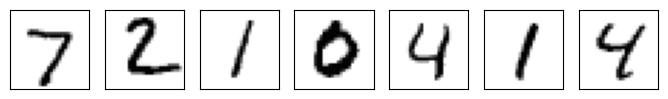


Reconstructed Images:


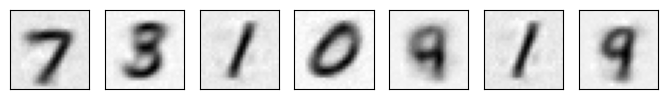

Epoch: 1, Train Loss: 44.21542, Test Loss: 40.73106, Training Time:   4.64 seconds
Original Images:


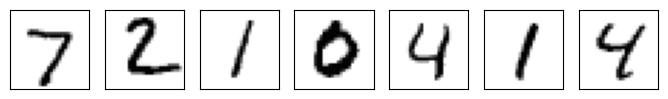


Reconstructed Images:


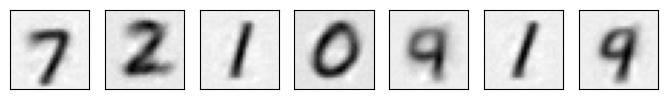

Epoch: 2, Train Loss: 39.68628, Test Loss: 39.10736, Training Time:   4.27 seconds
Original Images:


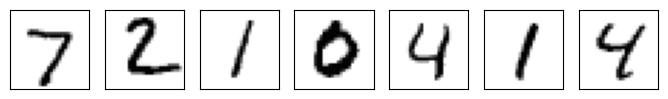


Reconstructed Images:


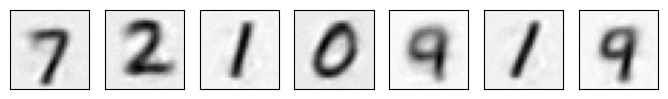

Epoch: 3, Train Loss: 38.33775, Test Loss: 37.93486, Training Time:   4.57 seconds
Original Images:


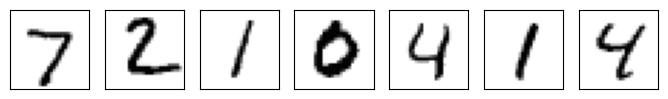


Reconstructed Images:


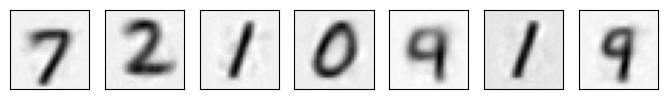

Epoch: 4, Train Loss: 37.52735, Test Loss: 37.29655, Training Time:   4.29 seconds
Original Images:


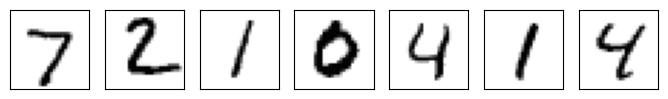


Reconstructed Images:


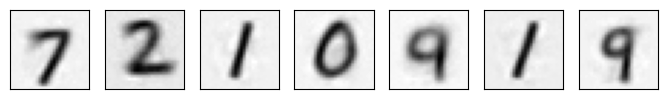

Epoch: 5, Train Loss: 37.01804, Test Loss: 36.78532, Training Time:   5.16 seconds
Original Images:


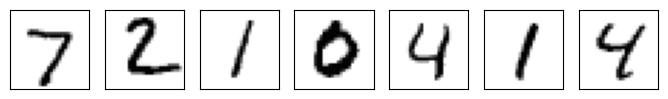


Reconstructed Images:


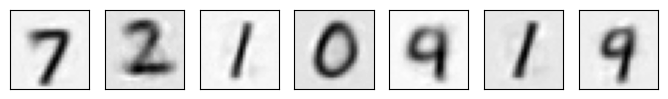

Epoch: 6, Train Loss: 36.60633, Test Loss: 36.66661, Training Time:   5.03 seconds
Original Images:


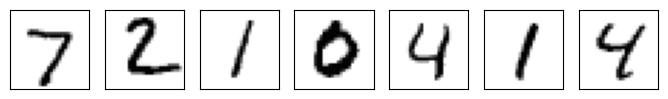


Reconstructed Images:


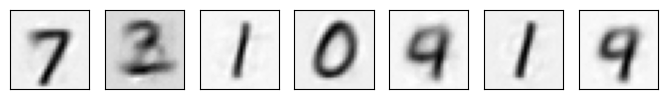

Epoch: 7, Train Loss: 36.26526, Test Loss: 36.29319, Training Time:   4.76 seconds
Original Images:


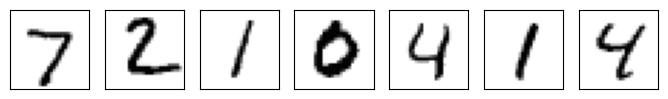


Reconstructed Images:


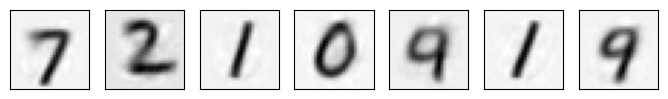

Epoch: 8, Train Loss: 36.05853, Test Loss: 36.11555, Training Time:   5.27 seconds
Original Images:


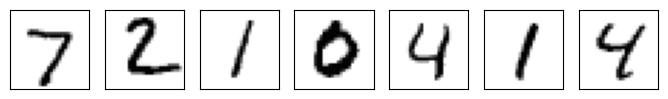


Reconstructed Images:


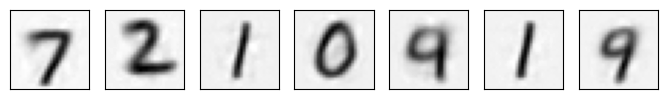

Epoch: 9, Train Loss: 35.88940, Test Loss: 36.00667, Training Time:   5.01 seconds
Original Images:


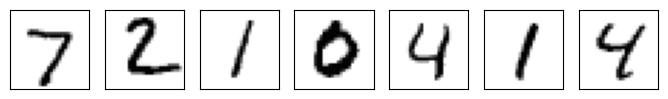


Reconstructed Images:


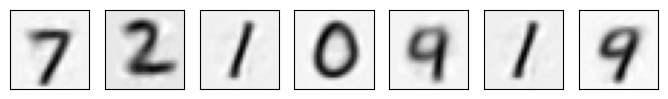

Epoch: 10, Train Loss: 35.68260, Test Loss: 35.71755, Training Time:   4.82 seconds
Original Images:


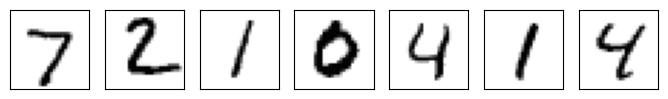


Reconstructed Images:


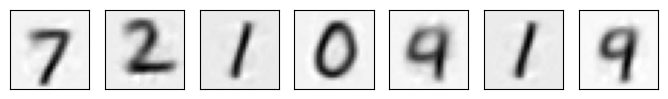

Epoch: 11, Train Loss: 35.52264, Test Loss: 35.66843, Training Time:   4.41 seconds
Original Images:


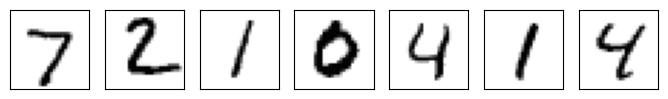


Reconstructed Images:


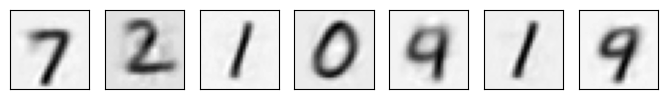

Epoch: 12, Train Loss: 35.38888, Test Loss: 35.66062, Training Time:   4.18 seconds
Original Images:


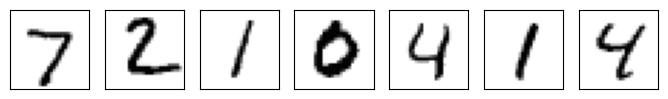


Reconstructed Images:


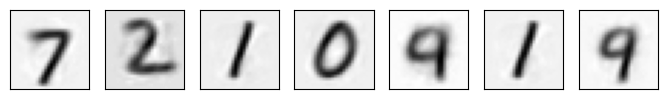

Epoch: 13, Train Loss: 35.27143, Test Loss: 35.39852, Training Time:   4.36 seconds
Original Images:


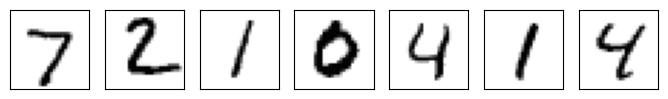


Reconstructed Images:


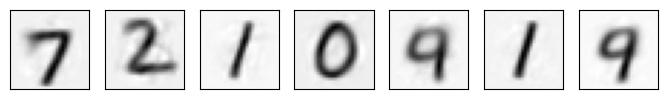

Epoch: 14, Train Loss: 35.10320, Test Loss: 35.33158, Training Time:   4.43 seconds
Original Images:


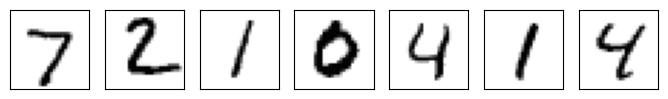


Reconstructed Images:


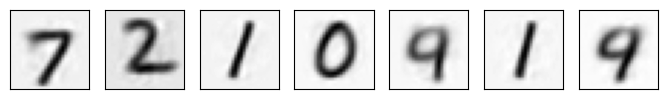

Epoch: 15, Train Loss: 34.99662, Test Loss: 35.36949, Training Time:   5.11 seconds
Original Images:


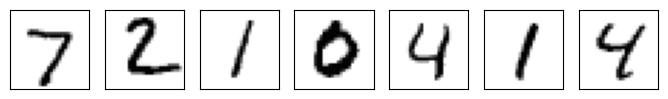


Reconstructed Images:


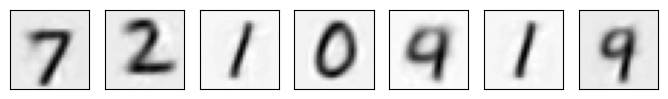

Epoch: 16, Train Loss: 34.99850, Test Loss: 34.99694, Training Time:   4.62 seconds
Original Images:


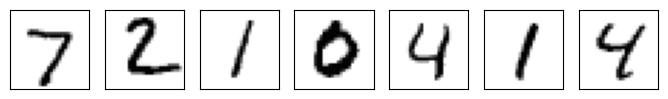


Reconstructed Images:


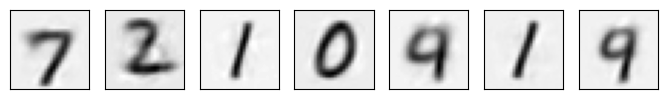

Epoch: 17, Train Loss: 34.81912, Test Loss: 35.02225, Training Time:   4.20 seconds
Original Images:


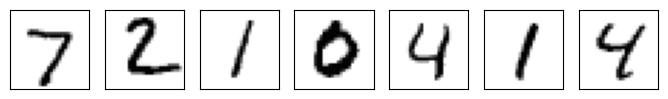


Reconstructed Images:


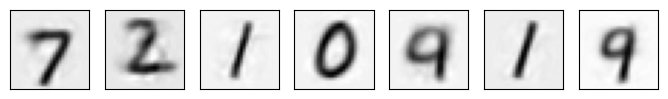

Epoch: 18, Train Loss: 34.70973, Test Loss: 35.24245, Training Time:   4.18 seconds
Original Images:


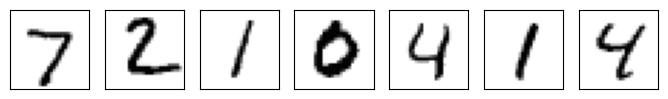


Reconstructed Images:


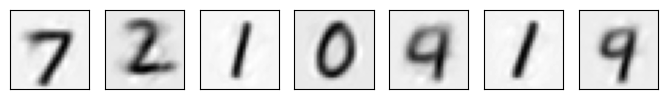

Epoch: 19, Train Loss: 34.71134, Test Loss: 35.11403, Training Time:   4.29 seconds
Original Images:


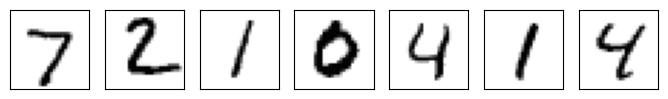


Reconstructed Images:


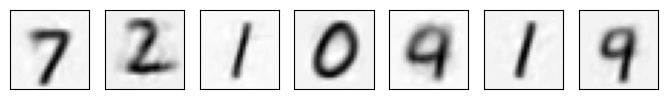

Epoch: 20, Train Loss: 34.59174, Test Loss: 34.83593, Training Time:   4.26 seconds
Original Images:


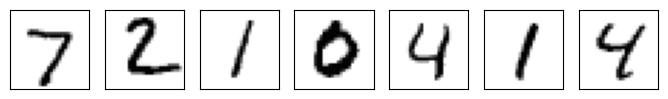


Reconstructed Images:


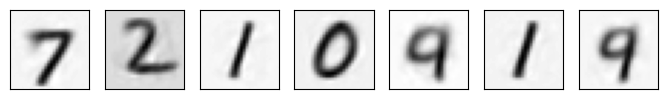

Epoch: 21, Train Loss: 34.53210, Test Loss: 34.93360, Training Time:   5.21 seconds
Original Images:


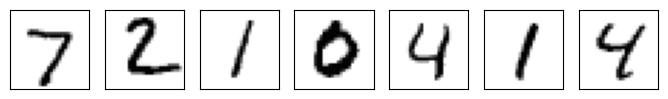


Reconstructed Images:


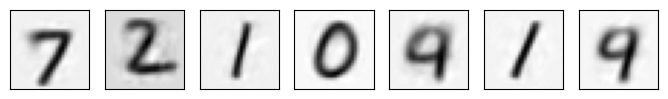

Epoch: 22, Train Loss: 34.47439, Test Loss: 34.76270, Training Time:   4.52 seconds
Original Images:


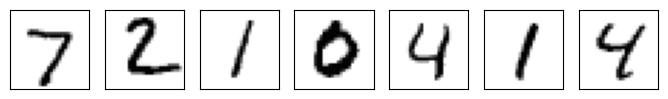


Reconstructed Images:


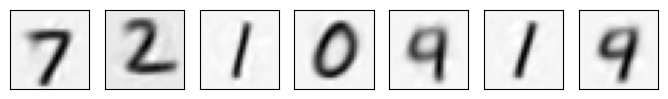

Epoch: 23, Train Loss: 34.49122, Test Loss: 34.78744, Training Time:   4.91 seconds
Original Images:


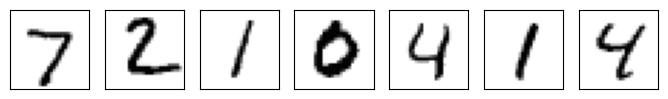


Reconstructed Images:


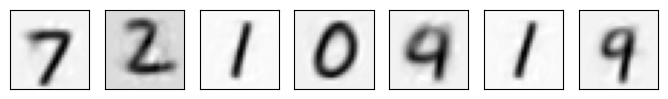

Epoch: 24, Train Loss: 34.37103, Test Loss: 34.69583, Training Time:   4.83 seconds
Original Images:


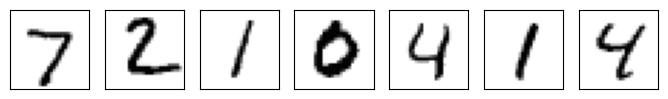


Reconstructed Images:


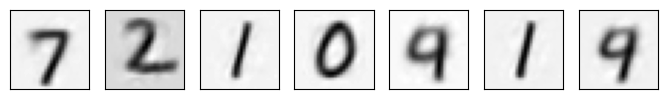

Epoch: 25, Train Loss: 34.33255, Test Loss: 34.91089, Training Time:   7.27 seconds


In [49]:
grading_env_var = os.getenv('NBGRADER_EXECUTION', None)
is_grading = (grading_env_var == "autograde" or grading_env_var == "validate")

# Falls ihr hier etwas ändert, bitte darauf achten, dass diese If-Abfrage nicht entfernt wird.
# Ansonsten wird das auto-grading zu lange dauern und abbrechen.
if not is_grading:
    torch.manual_seed(42)  # Set seed for reproducibility

    # Define an optimizer. This updates the weights depending on the gradient. We are using the Adam optimizer here
    # Adam is the de-facto standard optimizer for general neural networks. We use a learning rate of 1e-3.

    # Initialize the Autoencoder and optimizer
    autoencoder = Autoencoder(data_dims=(28,28), hidden_dims_enc=(512, 256), latent_dims=2, hidden_dims_dec=(256, 512))
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3) 
    epochs = 25  # Number of training epochs

    # Training loop
    for epoch in range(epochs):
        start_time = time.time()

        train_loss = 0
        test_loss = 0
        for batch_idx, (x, _y) in enumerate(train_loader):
            # the gradients accumulate, so we need to zero_grad() them every iteration
            optimizer.zero_grad()  # Reset gradients
            reconstruction = autoencoder(x)  # Forward pass
            loss = reconstruction_loss(x, reconstruction) + autoencoder.encoder.kl # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            train_loss += loss.item()
        
        # compute test error, we do not need gradients for that, hence the torch.no_grad() block
        with torch.no_grad():
            for batch_idx, (x, _y) in enumerate(test_loader):
                reconstruction = autoencoder(x) # Forward pass
                loss = reconstruction_loss(x, reconstruction) + autoencoder.encoder.kl # Compute loss
                test_loss += loss.item()
            train_loss /= len(train_loader)
            test_loss /= len(test_loader)
            plot_reconstructions(autoencoder.encoder, autoencoder.decoder, next(iter(test_loader)))
            print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.5f}, Test Loss: {test_loss:.5f}, Training Time: {(time.time() - start_time):6.2f} seconds")


Nachdem wir nun das Netzwerk trainiert haben, können wir uns nun den zweidimensionalen Latent Space anzeigen. Wir sehen, wie die Daten im Latent Space nach den Ziffern 0-9 gruppiert sind und näherungsweise radial um den Ursprung verteilt sind. Durch den KL-Term in der Loss-Funktion sind die Datenpunkte im Latent Space näherungsweise normalverteilt.

In [50]:
def plot_latent(autoencoder, data_loader, num_batches=100):

    autoencoder.eval()  # Set the model to evaluation mode

    all_z = []  # To store latent variables
    all_labels = []  # To store corresponding labels

    with torch.no_grad():  # No gradients needed
        for i, (x, y) in enumerate(data_loader):
            if i >= num_batches:
                break

            # Get latent space representation
            z = autoencoder.encoder(x)  # Forward pass through encoder
            all_z.append(z)  # Store latent variables
            all_labels.append(y)  # Store labels

    # Concatenate all latent variables and labels
    all_z = torch.cat(all_z, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    # Plot the latent space
    plt.figure(figsize=(10, 8))

    # Create scatter plot
    scatter = plt.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
    
    # Customize the colorbar
    num_classes = len(np.unique(all_labels))
    cbar = plt.colorbar(scatter, ticks=[(num_classes-1)/num_classes/2 + i * (num_classes-1)/num_classes for i in range(num_classes)])  # Set ticks at class boundaries
    cbar.ax.set_yticklabels([i for i in range(num_classes)])  # Label each tick
    cbar.set_label("Class", rotation=270, labelpad=20)

    # Add plot labels and title
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    # plt.show()

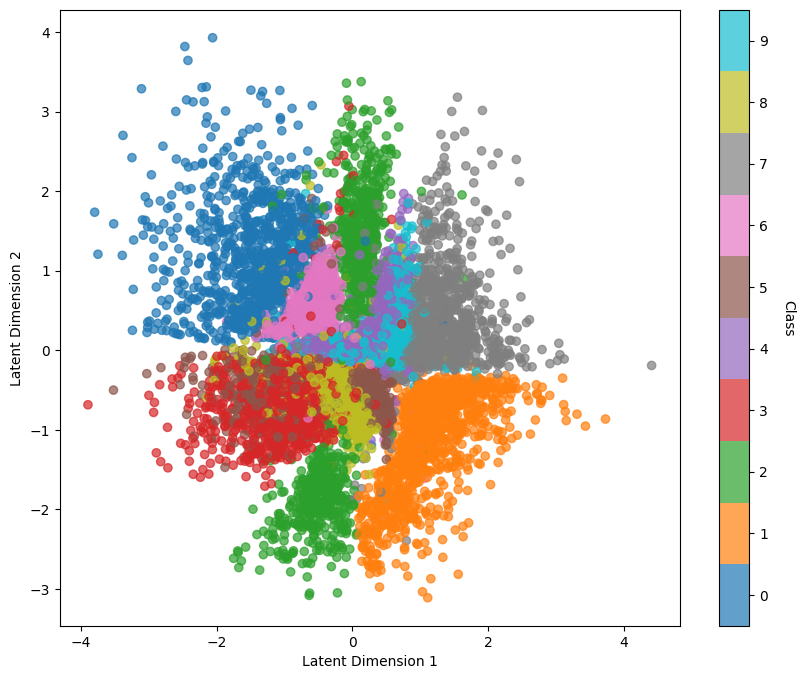

In [51]:
plot_latent(autoencoder, test_loader)

Wir können uns auch die Rekonstruktionen der Eingabedaten an verschiedenen Stellen im Latent Space ansehen. Auch hier sind die Bereiche der einzelnen Ziffern klar erkennbar.

In [52]:
def plot_reconstructed(autoencoder, latent_range_x=(-3, 3), latent_range_y=(-3, 3), grid_size=12):

    image_size = 28  # Size of each reconstructed image (28x28 for MNIST)
    grid_image = np.zeros((grid_size * image_size, grid_size * image_size))  # Grid to hold images

    for row_index, latent_y in enumerate(np.linspace(*latent_range_y, grid_size)):
        for col_index, latent_x in enumerate(np.linspace(*latent_range_x, grid_size)):
            latent_vector = torch.Tensor([[latent_x, latent_y]])  # Latent vector
            reconstructed_image = autoencoder.decoder(latent_vector)  # Decode the latent vector
            reconstructed_image = reconstructed_image.reshape(image_size, image_size).detach().numpy()
            grid_y_start = (grid_size - 1 - row_index) * image_size
            grid_y_end = grid_y_start + image_size
            grid_x_start = col_index * image_size
            grid_x_end = grid_x_start + image_size
            grid_image[grid_y_start:grid_y_end, grid_x_start:grid_x_end] = reconstructed_image

    # Plot the grid of reconstructed images
    plt.figure(figsize=(10, 8))
    plt.imshow(1-grid_image, cmap='gray', extent=[*latent_range_x, *latent_range_y], interpolation='nearest')
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.show()

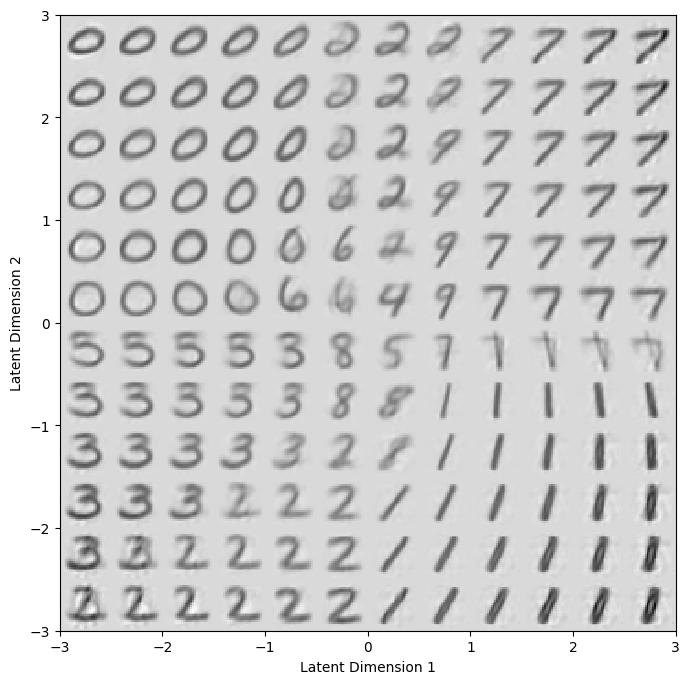

In [53]:
plot_reconstructed(autoencoder)

## Aufgabe 3.5 (3 Punkte) - Interpolation

Bilder können ineinander umgewandelt werden, in dem die Codes linear interpoliert und anschließend rücktransformiert werden. Vervollständigt dafür die `morph()` Funktion im folgenden Feld. Die Argumente der Funktion sind das Anfangs- und das Endbild sowie die Anzahl der Zwischenbilder.

Hinweise: 
- Ihr könnt hier die `autoencoder.encode()` und `autoencoder.decode()` Funktionen verwenden (siehe Implementierung des Autoencoders), um die Latenten Repräsentationen zu erhalten und zurück zu transformieren.
- Ihr könnt `torch.stack` verwenden, um einen Batch für den Encoder zu erstellen
- Ein `torch.Tensor` kann durch `.detach().numpy()`in einen Numpy-Array umgewandelt werden.
- Ihr könnt mit `torch.unsqueeze(image, 0)` und `torch.squeeze()` eine Batch-Dimension zu einem einzelen Bild hinzufügen bzw. davon entfernen.

In [54]:
def morph(autoencoder, image_1, image_2, num_intermediate_images):
    """
    Performs morphing between two images in the latent space of the autoencoder.
    
    Args:
        image_1 (torch.Tensor): Input tensor of the first image, shape (28, 28).
        image_2 (torch.Tensor): Input tensor of the second image, shape (28, 28).
        num_intermediate_images (int): Number of intermediate images to generate.
    
    Returns:
        output_imgs (list of numpy.ndarray): List of reconstructed images including intermediates.
            - The first image is the reconstruction of `image_1`.
            - The last image is the reconstruction of `image_2`.
            - The intermediate images are decoded from interpolated latent codes.
        code1 (torch.Tensor): Latent code of `image_1`, shape (latent_dims).
        code2 (torch.Tensor): Latent code of `image_2`, shape (latent_dims).
    """
    with torch.no_grad():
        ### BEGIN SOLUTION
        code1, code2 = autoencoder.encode(torch.stack([image_1, image_2]))
        output_imgs = []
        for t in torch.linspace(0, 1, steps=num_intermediate_images+2):
            new_code = code2 * t + code1 * (1-t)
            new_img = autoencoder.decode(torch.unsqueeze(new_code, 0)).squeeze().detach().numpy()
            output_imgs.append(new_img)
        ### END SOLUTION
    return output_imgs, code1, code2

**Reise durch den Latent Space:**

Mit der implementierten `morph`-funktion könnt ihr jetzt eine Reise durch den Latent Space unternehmen. Wählt dazu zwei Bilder aus dem Testdatensatz und lasst euch die interpolierten Bilder anzeigen. Wir können so sehen, wie sich die Rekonstruktionen der Bilder verändern, wenn wir uns durch den Latent Space bewegen und die einzelnen Ziffern ineinander übergehen. Wir plotten hier auch nocheinmal den Latent Space und zeigen die Koordinaten der kodierten Bilder und die Route über die wir uns durch den Latent Space bewegen. So könnt ihr hier nochmal sehen, wie wir uns durch die verschiedenen Bereiche der einzelenen Ziffern bewegen.

Original images:


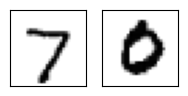

Morphed sequence:


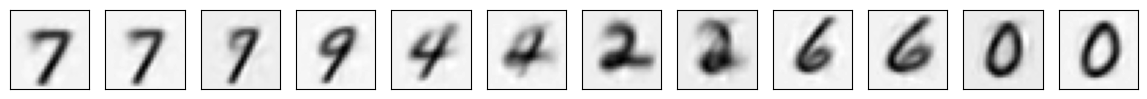

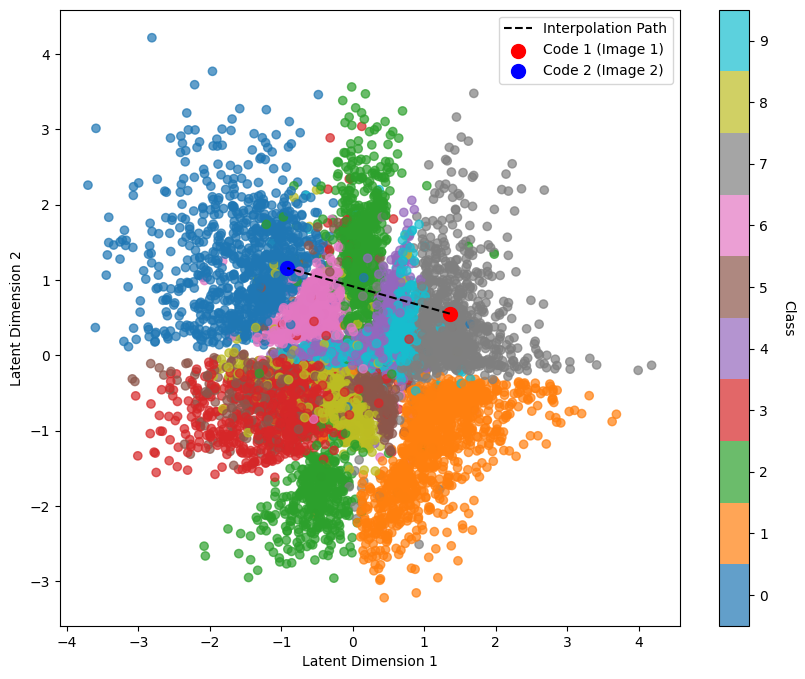

In [55]:
# Select two images from the test set
# Modify the indices to experiment with different images
image_1_idx, image_2_idx = 0, 3
image_1, image_2 = test_dataset[image_1_idx][0], test_dataset[image_2_idx][0]

# Visualize the original images
print("Original images:")
visualize_data([image_1, image_2])

# Generate the morphed sequence of images
num_morphed_images = 10  # Number of intermediate images
print("Morphed sequence:")
morphed_images, code1, code2 = morph(autoencoder, image_1, image_2, num_morphed_images)
visualize_data(morphed_images)

# Visualize the latent space and morphed path
plot_latent(autoencoder, test_loader)  # Plot the latent space

# Add a line between the two latent codes to visualize the interpolation path
plt.plot(
    [code1[0], code2[0]], 
    [code1[1], code2[1]], 
    color='black', linestyle='--', label='Interpolation Path'
)

# Highlight the latent codes of the original images
plt.scatter(
    [code1[0]], [code1[1]], 
    color='red', s=100, label='Code 1 (Image 1)'
)
plt.scatter(
    [code2[0]], [code2[1]], 
    color='blue', s=100, label='Code 2 (Image 2)'
)

# Add legend and show the plot
plt.legend()
plt.show()

Jetzt folgen noch ein paar Tests, um zu überprüfen, ob der Code funktioniert:

In [56]:
t1, t2, n_steps = torch.randint(high=10,size=[28,28])/2, torch.randint(high=10,size=[28,28])/2, 6

class TestAutoencoder:
    """
    A mock autoencoder class for testing purposes. Passes data through identity transformations.
    Args:
        autoencoder (tuple): A tuple of two torch.nn.Module objects (encoder and decoder).
    """
    def __init__(self, autoencoder):
        self.encoder = autoencoder[0]  # Encoder module
        self.decoder = autoencoder[1]  # Decoder module

    def encode(self, x):
        """Encodes input data."""
        return self.encoder(x)

    def decode(self, z):
        """Decodes latent space representation."""
        return self.decoder(z)

# Instantiate the mock autoencoder for testing
test_autoencoder = TestAutoencoder((torch.nn.Identity(), torch.nn.Identity()))

# Call the morph function
student_interpolation = morph(test_autoencoder, t1, t2, n_steps)

assert len(student_interpolation[0]) == (n_steps + 2), (
    f"Expected {n_steps + 2} images in the morphed sequence, but got {len(student_interpolation[0])}."
)

for i in range(n_steps + 2):
    expected_img = (5 * ((i * t2 + (n_steps + 1 - i) * t1) / (n_steps + 1)).detach().numpy()).round(4)
    actual_img = (5 * student_interpolation[0][i]).round(4)
    assert np.array_equal(actual_img, expected_img), (
        f"Mismatch at step {i}. "
        f"Expected:\n{expected_img}\n\nGot:\n{actual_img}"
    )

assert student_interpolation[1].shape == (28, 28), (
    f"Expected shape of the first code to be (28, 28), but got {student_interpolation[1].shape}."
)
assert student_interpolation[2].shape == (28, 28), (
    f"Expected shape of the second code to be (28, 28), but got {student_interpolation[2].shape}."
)
assert student_interpolation[0][0].shape == (28, 28), (
    f"Expected shape of the first image in the sequence to be (28, 28), but got {student_interpolation[0][0].shape}."
)

Generated Images:


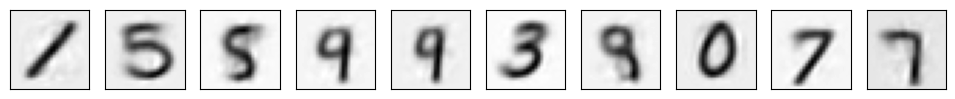

In [74]:
generated_images = autoencoder.generate(10)

print("Generated Images:")
generated_images = [img.detach() for img in generated_images]
visualize_data(generated_images)


Dies ist das Ende der Programmieraufgabe. **Vergesst nicht, auch die Fragen auf dem Übungsblatt zu beantworten** ;)

In [1]:
'''Example for PCA'''
import numpy as np
data = np.array([[1, 1], [1, -1], [-1, -1], [-1, 1]])
cov_matrix = np.cov(data.T) # Calculate the covariance matrix
cov_matrix

array([[1.33333333, 0.        ],
       [0.        , 1.33333333]])